In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate

def display(data, message):
    print(message)
    print(tabulate(data, headers="keys", tablefmt="HTML"))
    print()

def preprocess_weather(k, v):
    print(k, v)
    data = pd.read_excel(v)
    data["Origin AirportArr"] = k
    data["Date"] = data["time"].dt.date
    data["Scheduled departure hour"] = data["time"].dt.hour
    data["Scheduled departure hour"].astype("str")
    display(data.head(10), "Weather")
    return data

def weather_data():
    kv = {"ORD": "/content/ORD_weather.xlsx",
          "EWR": "/content/EWR_weather.xlsx",
          "DEN": "/content/DEN_weather.xlsx",
          "IAD": "/content/IAD_weather.xlsx"}

    ORD_weather = preprocess_weather("ORD", kv["ORD"])
    EWR_weather = preprocess_weather("EWR", kv["EWR"])
    DEN_weather = preprocess_weather("DEN", kv["DEN"])
    IAD_weather = preprocess_weather("IAD", kv["IAD"])
    ORD_weather.to_excel("/content/ORD_processed_weather.xlsx")
    EWR_weather.to_excel("/content/EWR_processed_weather.xlsx")
    DEN_weather.to_excel("/content/DEN_processed_weather.xlsx")
    IAD_weather.to_excel("/content/IAD_processed_weather.xlsx")
    return

def combine_weather_flight():
    ORD_weather = pd.read_excel("/content/ORD_processed_weather.xlsx")
    EWR_weather = pd.read_excel("/content/EWR_processed_weather.xlsx")
    DEN_weather = pd.read_excel("/content/DEN_processed_weather.xlsx")
    IAD_weather = pd.read_excel("/content/IAD_processed_weather.xlsx")
    weather_data = pd.concat([ORD_weather, EWR_weather, DEN_weather, IAD_weather], ignore_index = True)

    print(len(weather_data))
    flight_data = pd.read_excel("/content/combined_csv.xlsx")
    flight_data["Date"] = flight_data["Date"].dt.date
    flight_data["Date"] = pd.to_datetime(flight_data["Date"])
    flight_data["Scheduled departure hour"] = pd.to_datetime(flight_data["Scheduled departure time"], format="%H:%M").dt.hour

    display(weather_data.head(), "WEather")
    display(flight_data.head(), "Flight")

    final = flight_data.merge(weather_data, how = "inner", on = ["Date", "Scheduled departure hour", "Origin AirportArr"])

    display(final, "")
    final.to_excel("/content/combined_flight_weather.xlsx")

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [47]:
data = pd.read_excel("/content/preprocssed_flight_weather (2).xlsx")
data.drop(columns = ['Unnamed: 0', 'Carrier Code_Arr'], inplace = True)

# data = data[(data['Date'].dt.month==4) | (data['Date'].dt.month==3) | (data['Date'].dt.month==5)] 
# | (data['Date'].dt.month==6) | (data['Date'].dt.month==7) | (data['Date'].dt.month==8) | (data['Date'].dt.month==9)]

# data = data[data['Date'].dt.month==4]

data['Scheduled Arrival hour'] = pd.to_datetime(data['Scheduled Arrival Time'], format = '%H:%M').dt.hour
data['Scheduled Arrival minutes'] = pd.to_datetime(data['Scheduled Arrival Time'], format = '%H:%M').dt.minute
# data['day_of_week'] = if data['Date'].dt.weekday

# df['my_dates'] = pd.to_datetime(df['my_dates'])
data['day_of_week'] = data['Date'].dt.dayofweek

days = {0:0,1:0,2:0,3:0,4:1,5:1,6:1}

data['day_of_week'] = data['day_of_week'].apply(lambda x: days[x])
data.drop(columns = ['Date', 'Flight Number', 'Origin AirportArr', 'Scheduled Arrival Time',
                     'Scheduled departure time', 'Departure delay (Minutes)', 'Arrival Delay (Minutes)',
                     'time', 'surface_pressure (hPa)', 'snowfall (cm)', 'windspeed_100m (km/h)', 
                     'windspeed_10m (km/h)', 'temperature_2m (°C)', 'rain (mm)', 'weathercode (wmo code)',
                     'Scheduled elapsed time (Minutes)', 'Scheduled Elapsed Time (Minutes)', 
                     'Delay Carrier (Minutes)_Arr', 'Destination Airport_Dep'], inplace = True)

# data.drop(columns = ['Date', 'Flight Number', 'Origin AirportArr', 'Scheduled Arrival Time',
#                      'Scheduled departure time', 'Departure delay (Minutes)', 'Arrival Delay (Minutes)',
#                      'time',  
#                      'Delay Carrier (Minutes)_Arr', 'Destination Airport_Dep'], inplace = True)

Origin Airport_Dep


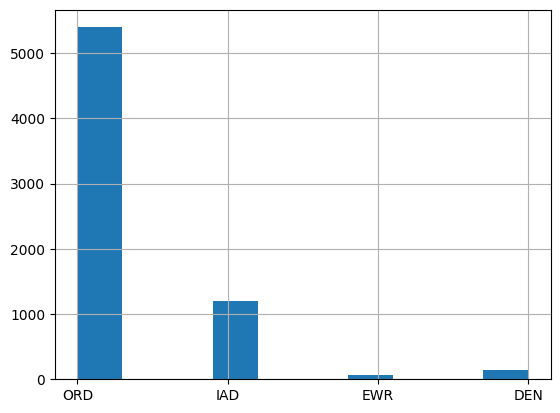

Scheduled departure hour


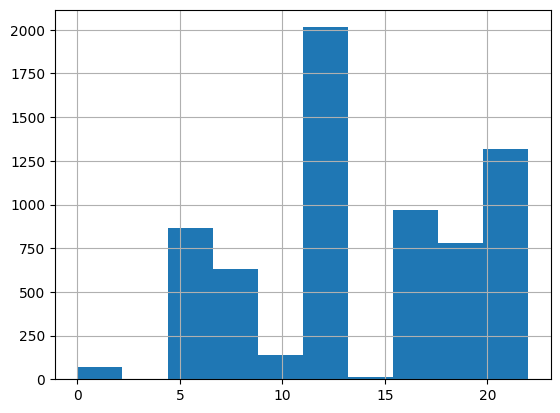

Arrival delay (cat)


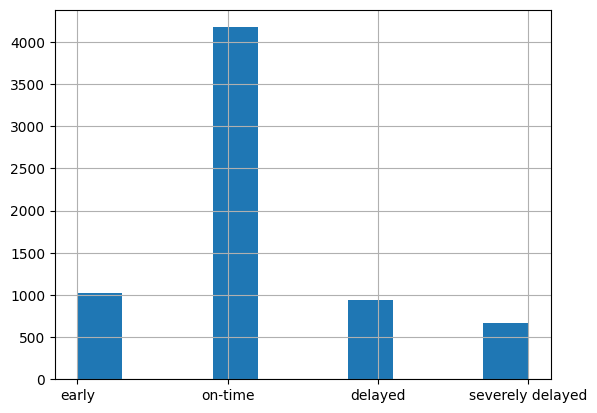

Scheduled Arrival hour


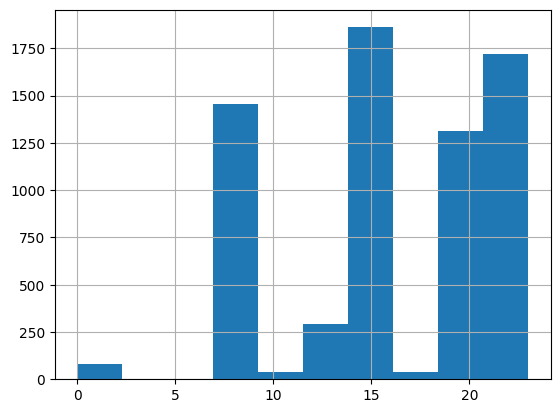

Scheduled Arrival minutes


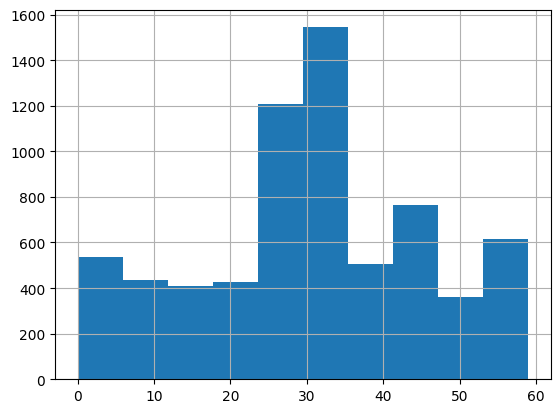

day_of_week


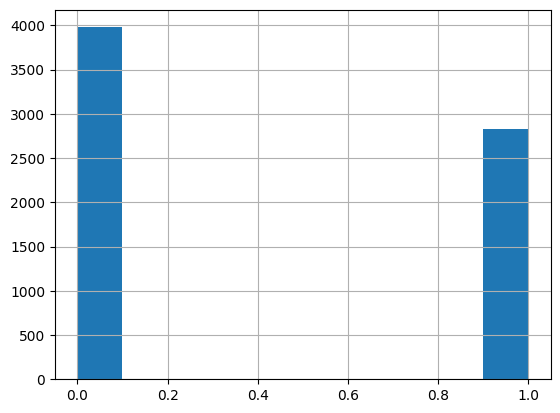

In [48]:
for col in data.columns: 
    data[col].hist()
    print(col)
    plt.show()

In [3]:
data = pd.read_excel("/content/preprocssed_flight_weather (2).xlsx")

<ipython-input-38-3ee73c814820>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


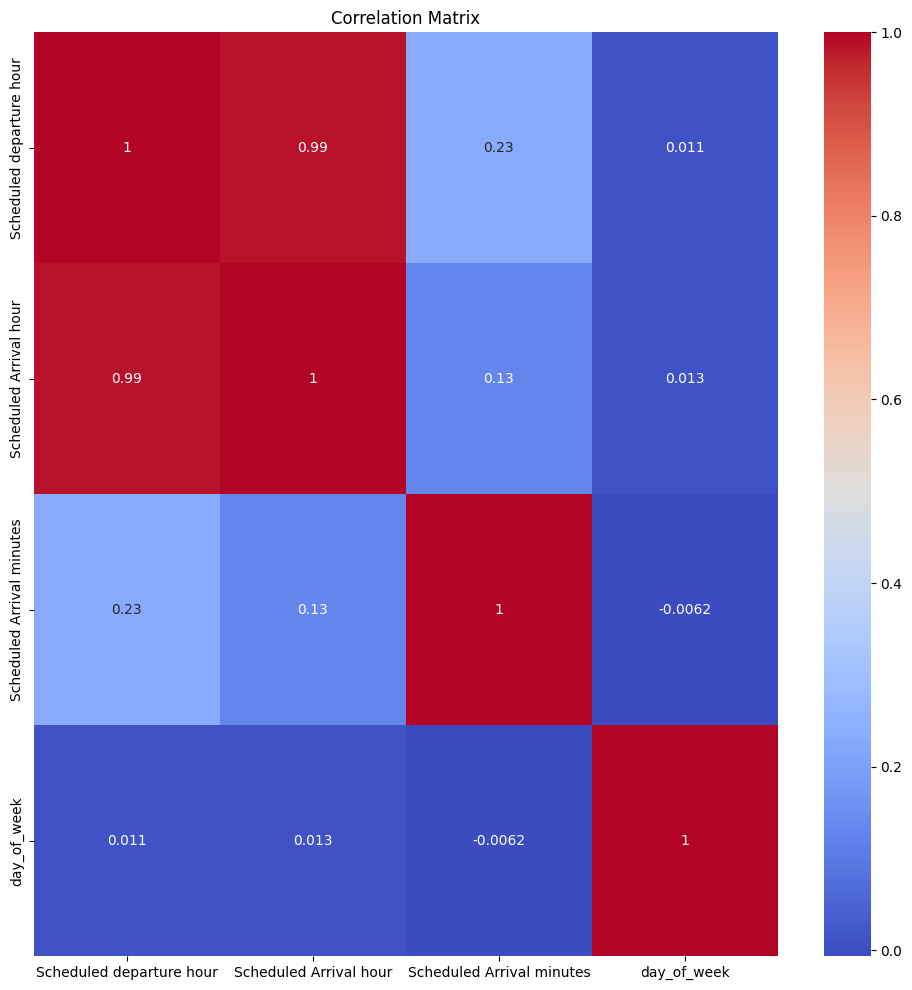

In [38]:
corr = data.corr()

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [5]:
data.shape

(6802, 24)

In [11]:
list(data.columns)

['Scheduled Elapsed Time (Minutes)',
 'Arrival Delay (Minutes)',
 'Scheduled elapsed time (Minutes)',
 'Departure delay (Minutes)',
 'Origin Airport_Dep',
 'Scheduled departure hour',
 'temperature_2m (°C)',
 'surface_pressure (hPa)',
 'rain (mm)',
 'snowfall (cm)',
 'weathercode (wmo code)',
 'windspeed_10m (km/h)',
 'windspeed_100m (km/h)',
 'Arrival delay (cat)',
 'Scheduled Arrival hour',
 'Scheduled Arrival minutes',
 'day_of_week']

In [ ]:
data['Arrival delay (cat)'].value_counts()

on-time             612
early               164
delayed             139
severely delayed     95
Name: Arrival delay (cat), dtype: int64

In [39]:
from sklearn.preprocessing import LabelEncoder

# Instantiate a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to the string labels and transform them to integers
# data['Arrival delay Ord'] = le.fit_transform(data['Arrival delay (cat)'])


from sklearn.preprocessing import OrdinalEncoder

# create an instance of the OrdinalEncoder class
enc = OrdinalEncoder()

# select the categorical columns to be transformed
cat_cols = ['Origin Airport_Dep']

# fit and transform the categorical columns
data[cat_cols] = enc.fit_transform(data[cat_cols])
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['Arrival delay (cat)']), 
                                                    data['Arrival delay (cat)'] , test_size=0.8, random_state=50)
# fit model no training data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept = True, solver='newton-cg', multi_class = 'multinomial', penalty = 'none', max_iter = 1000)
# model = LogisticRegression(fit_intercept = True, solver='lbfgs', multi_class = 'ovr', penalty = 'none', max_iter = 1000)
# model = LogisticRegression(fit_intercept = True, solver='lbfgs', multi_class = 'multinomial', penalty = 'none', max_iter = 1000)
# model = LogisticRegression(fit_intercept = True, solver='newton-cg', multi_class = 'multinomial', penalty = 'none', max_iter = 10000)

# While using multiclass case do multi_class = 'ovr' or 'auto'; can also try other solvers
# While doing regularization, use penalty = 'l2' and also C = 10.0 (need to try other values too)

model.fit(X_train, y_train) 

# The following gives the mean accuracy on the given data and labels
print("Score is : ", model.score(X_train, y_train) )
model.score(X_train, y_train) 

# This is the coefficient Beta_1, ..., Beta_7
model.coef_

# This is the coefficient Beta_0
model.intercept_

Score is :  0.5594059405940595


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([-4.09242623,  0.97073327,  1.76353416,  1.35815879])

In [42]:
from xgboost import XGBClassifier
model = XGBClassifier()

cat_cols = ['Origin Airport_Dep', 'Arrival delay (cat)']

data[cat_cols] = enc.fit_transform(data[cat_cols])
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['Arrival delay (cat)']), 
                                                    data['Arrival delay (cat)'] , test_size=0.8, random_state=50)

model.fit(X_train, y_train)

print("Score is : ", model.score(X_train, y_train) )
model.score(X_train, y_train) 

Score is :  0.7326732673267327


0.7326732673267327

In [41]:
print(X_train.columns)
len(X_train.columns)

Index(['Origin Airport_Dep', 'Scheduled departure hour',
       'Scheduled Arrival hour', 'Scheduled Arrival minutes', 'day_of_week'],
      dtype='object')


5

In [43]:
print("Score is : ", model.score(X_test, y_test) )

Score is :  0.44554455445544555


In [ ]:
X_train.head()

,Origin Airport_Dep,Scheduled departure hour,Scheduled Arrival hour,Scheduled Arrival minutes,day_of_week
6467,2.0,22,23,37,0
5909,3.0,18,20,49,0
1266,3.0,16,19,30,1
2533,3.0,6,9,26,0
1377,2.0,21,22,48,1


In [ ]:
# for 21-24th April predictions

from sklearn.preprocessing import OrdinalEncoder

# create an instance of the OrdinalEncoder class
enc = OrdinalEncoder()

import pandas as pd

pred_data = pd.read_csv("/content/project csv(Apr 21-24).csv")
Dep = ["7:10","13:55","18:40","7:10","13:55","18:40","7:10","14:00","18:40","7:10","13:55","18:40","9:51","9:51","9:51","9:51","9:15","22:30","9:15","22:05","9:15","22:30","9:15","22:30","12:43","17:36","12:43","17:36","12:43","17:36","12:43","17:36"]
pred_data.drop(columns = ['Status (Early, On-time, Late, Severly Late)'], inplace = True)

Dep = Dep + [None] * (len(pred_data) - len(Dep))

pred_data['Scheduled departure time'] = Dep
pred_data.dropna(inplace = True)
pred_data['Scheduled departure time'] = pd.to_datetime(pred_data['Scheduled departure time'])
pred_data['Origin AirportArr'] =  pred_data['Origin Airport']
pred_data['Date'] = pred_data['Date'].astype(str)
pred_data['Date'] = pred_data['Date'].apply(lambda x: x.replace('/', '-'))
pred_data['Date'] = pd.to_datetime(pred_data['Date'])
pred_data['Scheduled departure hour'] = pd.to_datetime(pred_data['Scheduled departure time']).dt.hour
pred_data['Scheduled Arrival hour'] = pd.to_datetime(pred_data['Arrival Time'], format='%I:%M %p').dt.hour
pred_data['Scheduled Arrival minutes'] = pd.to_datetime(pred_data['Arrival Time'], format='%I:%M %p').dt.minute
pred_data['Origin Airport_Dep'] = pred_data['Origin AirportArr']
pred_data['day_of_week'] = pred_data['Date'].dt.dayofweek
pred_data['day_of_week'] = pred_data['day_of_week'].astype(int)

days = {0:0,1:0,2:0,3:0,4:1,5:1,6:1}

pred_data['day_of_week'] = pred_data['day_of_week'].apply(lambda x: days[x])

pred_data.drop(columns = ['Flight Number', 'Date', 'Day', 'Origin Airport', 'Arrival Time',
                          'Scheduled departure time', 'Origin AirportArr'], inplace = True)
pred_data = pred_data.reindex(columns=['Origin Airport_Dep', 'Scheduled departure hour', 'Scheduled Arrival hour', 'Scheduled Arrival minutes', 'day_of_week'])
cat_cols = ['Origin Airport_Dep']

# fit and transform the categorical columns
pred_data[cat_cols] = enc.fit_transform(pred_data[cat_cols])

In [ ]:
len(Dep)

54

In [ ]:
pred_data.shape

(29, 5)

In [ ]:
y_pred = model.predict(pred_data)

In [ ]:
y_pred

array(['on-time', 'on-time', 'on-time', 'on-time', 'on-time', 'on-time',
       'on-time', 'on-time', 'on-time', 'early', 'on-time', 'on-time',
       'on-time', 'on-time', 'on-time', 'on-time', 'on-time', 'on-time',
       'on-time', 'on-time', 'on-time', 'on-time', 'on-time', 'on-time',
       'on-time', 'on-time', 'on-time', 'on-time', 'on-time', 'on-time',
       'on-time', 'on-time'], dtype=object)

In [ ]:
sub = pd.read_csv("/content/project csv(Apr 21-24).csv")

In [ ]:
sub.head(35)

,Date,Day,Origin Airport,Flight Number,Arrival Time,"Status (Early, On-time, Late, Severly Late)"
0,4/21/2023,Friday,ORD,UA 3839,10:00 AM,NaN
1,4/21/2023,Friday,ORD,UA 3524,4:50 PM,NaN
2,4/21/2023,Friday,ORD,UA 538,9:34 PM,NaN
3,4/22/2023,Saturday,ORD,UA 3839,10:00 AM,NaN
4,4/22/2023,Saturday,ORD,UA 3524,4:50 PM,NaN
5,4/22/2023,Saturday,ORD,UA 538,9:34 PM,NaN
6,4/23/2023,Sunday,ORD,UA 3839,10:00 AM,NaN
7,4/23/2023,Sunday,ORD,UA 3524,4:55 PM,NaN
8,4/23/2023,Sunday,ORD,UA 538,9:34 PM,NaN
9,4/24/2023,Monday,ORD,UA 3839,10:00 AM,NaN


In [ ]:
Dep = ["7:10","13:55","18:40","7:10","13:55","18:40","7:10","14:00","18:40","7:10","13:55","18:40","9:51","9:51","9:51","9:51","9:15","22:30","9:15","22:05","9:15","22:30","9:15","22:30","12:43","17:36","12:43","17:36","12:43","17:36","12:43","17:36"]
sub.drop(columns = ['Status (Early, On-time, Late, Severly Late)'], inplace = True)

Dep = Dep + [None] * (len(sub) - len(Dep))

sub['Scheduled departure time'] = Dep
sub.dropna(inplace = True)

In [ ]:
sub['Status (Early, On-time, Late, Severly Late)'] = y_pred

In [ ]:
sub.to_excel('submission.xlsx')